In [154]:
import numpy as np
import pandas as pd
from fastai.text.all import *
import fastai
print(fastai.__version__)
import matplotlib.pyplot as plt
from ipywidgets import interact

# Objective
- Classify review rating of Anime based text review using the dataset [MAL Top 10k Anime](https://www.kaggle.com/stoicstatic/mal-top-10k-anime-details?select=MAL+Anime+Top+10000+Details.csv)
- Utilize transfer learning for text classification task using fastai library

# Data exploration

In [157]:
reviews = pd.read_csv("/kaggle/input/mal-top-10k-anime-details/MAL Anime Reviews 85k.csv")

In [158]:
reviews.head()

,Anime Rank,Anime Title,Anime URL,Username,Review Date,Episodes Watched,Review Likes,Overall Rating,Story Rating,Animation Rating,Sound Rating,Character Rating,Enjoyment Rating,Review
0,1,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood/reviews,tazillo,"Jan 25, 2010",64 of 64 episodes seen,3464,10,10,9,9,10,10,"First of all, I have seen the original FMA and although it was very popular and original, the pacing and conclusion did not sit too well with me. Brotherhood is meant to be a remake of the original, this time sticking to the manga all the way through, but there were people who thought it would spoil the franchise. That myth should be dispelled, as there's only one word to describe this series - EPIC.\nI admit that as I've seen the original and read the manga, the pacing of Brotherhood seems to start off being VERY fast (I finally got used to the pacing after\nwatching the first fifteen eps..."
1,1,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood/reviews,Archaeon,"Nov 15, 2010",64 of 64 episodes seen,1311,9,8,9,9,9,9,"Adaptations have long been a thorn in the side of anime viewers, but not because they are inherently bad. No, the main problem has been that many studios have regarded the original work almost as an afterthought, and there are a number of shows that could have been wonderful if the writers had simply stuck to the original story.\nOne of the issues at hand seems to be ownership as producers, writers and directors all seem to want the work to be reflective of their style and perception, and in order to stamp their mark on a show they will makes numerous unnecessary changes or additions.\nAdm..."
2,1,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood/reviews,ChristopherKClaw,"Apr 7, 2015",64 of 64 episodes seen,1113,7,8,8,10,6,7,"Fullmetal Alchemist: Brotherhood gets an immense amount of praise in the MAL community, is the #1 ranked show and is constantly referred to as a masterpiece and the greatest show ever created. I've seen many fans preach about how ""it lives up to the hype"" and ""can never receive too much praise"". Now this is just the opinion of one guy. I'm certainly not the law of the land or anything. However, I personally feel as though calling FMA:B a masterpiece and the champion of all shows is a bit of a stretch. That's not to say that I didn't enjoy it or that it\nisn't a very solid addition to the r..."
3,1,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood/reviews,literaturenerd,"Apr 25, 2015",64 of 64 episodes seen,704,7,8,8,8,8,8,"Overview:\nFMA Brotherhood is an anime that needs no introduction. This is the highest rated anime on all of MAL. This is the anime that the current generation of anime fans holds above all others as the greatest single anime EVER made! In the following paragraphs, I will be reviewing this legendary series and discussing whether or not it truly deserves this title.\nSPOILERS for both Brotherhood and 2003 FMA!!!!\nPlot:\nThe plot takes place in the country of Armestris, which is basically like an alternate WW2 Germany. It is constantly at war for reasons that are less than just and is ruled..."
4,1,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood/reviews,M0nkeyD_Luffy,"Jul 29, 2015",64 of 64 episodes seen,446,5,2,7,7,8,5,"Since I couldn't find any legitimate objective analysis in any of these fanboy reviews, I decided put my own review:\nHere's why FMA:B and it's Manga counterpart don't work:\nIt's just a disjointed piece of art. The initial premise of the narrative: two young siblings that horrifically lose their mother and parts of themselves is incredibly dark and powerfully poignant. Their journey to find the philosophers stone is one that's objectively adventurous but the endpoint is still inherently adult

In [159]:
reviews["Review Date"] = pd.to_datetime(reviews["Review Date"])

In [160]:
print(f"total reviews: {len(reviews)}")
print(f"unique animes: {reviews['Anime Title'].nunique()}")
print(f"unique users: {reviews['Username'].nunique()}")
print(f"review date from {reviews['Review Date'].min()} - {reviews['Review Date'].max()}")

total reviews: 85953
unique animes: 4315
unique users: 35118
review date from 2006-11-07 00:00:00 - 2020-11-16 00:00:00


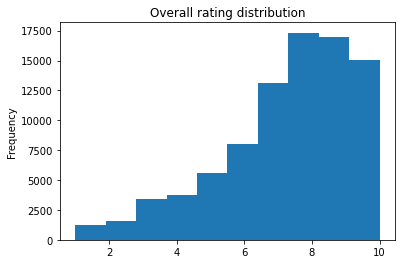

In [161]:
# overall rating distribution
_ = reviews["Overall Rating"].plot.hist()
_ = plt.title("Overall rating distribution")

In [162]:
# review word length
reviews["review_total_words"] = reviews["Review"].apply(lambda x: len(x.split(" ")))

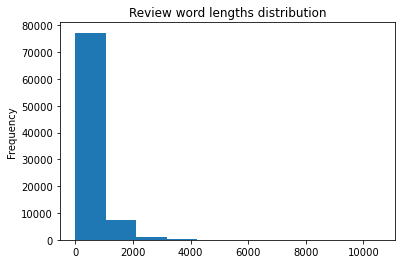

In [163]:
_ = reviews["review_total_words"].plot.hist()
_ = plt.title("Review word lengths distribution")

In [164]:
reviews["review_total_words"].describe()

count    85953.000000
mean       516.838551
std        495.528978
min          1.000000
25%        202.000000
50%        372.000000
75%        658.000000
max      10564.000000
Name: review_total_words, dtype: float64

In [165]:
# review per anime
review_per_anime = reviews.groupby("Anime Title")["Username"].count().reset_index()

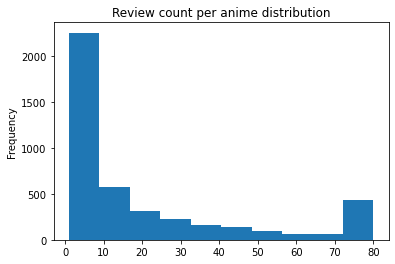

In [166]:
_ = review_per_anime["Username"].plot.hist()
_ = plt.title("Review count per anime distribution")

# Train model

In [167]:
dls = TextDataLoaders.from_df(reviews,text_col="Review",label_col="Overall Rating")

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [168]:
dls.show_batch()

,text,category
0,"xxbos * english is xxup not my first language ! xxmaj review / analysis / rant will be edited … eventually ! * \n "" it 's like watching two kids playing with their favourite action figurines , yelling at each other why one is so much better than the other , while someone presses every other minute the pause - button , and holds them still for about five to ten minutes - this goes on and on for fifty hours or so , straight ! "" \n - xxmaj xxunk , after 50 episodes of xxup dbz \n xxmaj first of all , let me tell you a little story , about how i ended up losing 100 hours of my life , into this … anime . xxmaj first of all , i never saw this anime when i was a \n kid , so … no",1
1,"xxbos xxup this xxup review xxup has xxup mild xxup spoilers xxup for xxup symphogear xxup xv . \n xxmaj senki xxmaj zesshou xxmaj symphogear the final season , xxup xv . xxmaj if i had to describe this season in one word it would be disappointing . \n i came into the 5th and final season of xxup xv very excited as the advertisement and teasers made it seem like it would be this amazing new season that broke the norm for xxmaj symphogear and deliver an epically told story . xxmaj with xxmaj miku also having an obvious focus in this season i was really excited because she 's been neglected since season 2 . xxmaj however all my hopes we 're quickly and utterly crushed . xxmaj the hibimiku we were promised and the hibimiku \n we get were two xxup hugely different things and its the",7
2,"xxbos xxmaj for decades , glorious xxmaj nippon has been growing closer to extinction . xxmaj to cure xxmaj nippon through the limitless power of anime , our lord and savior xxmaj trigger has blessed us with xxmaj darling in the franxx ! xxmaj but to our surprise , this anime was touched by xxmaj satan himself , xxup a-1 xxmaj pictures , and its true purpose was to accelerate the extinction ! ! \n ( long spoiler - filled review ahead . xxmaj spoiler - free xxup tl;dr at the end . ) \n xxmaj with the declining birthrate in xxmaj japan , people are living longer , but fewer babies are being born ; there are n’t enough young people to take care of the elderly . xxmaj the xxmaj japanese government is spending more money on health care , the workforce is shrinking with less young \n",1
3,"xxbos xxmaj it ’s xxmaj august 1st , 1 xxrep 3 9 ! \n xxmaj on this day exactly 20 years ago , these were the words spoken by an 11-year - old boy after discovering at his home in xxmaj odaiba during his summer vacation that … well , i do n’t want to spoil anyone here . xxmaj it ’s been exactly 2 full decades since that odd snowy summer day when 7 children were sucked by a giant wave into an unknown world where they would meet some small , strange talking creatures that claimed had been waiting for them for a long time and would live together the most important journey of their lives , kicking off the story of the 1st series of a franchise \n that , despite never reaching the levels of popularity of its most direct “ rival ” ( that only",9
4,"xxbos xxup warning : xxmaj this review contains spoilers for xxmaj darling in the xxmaj francisco , not that i would recommend you to watch it anyway . \n xxmaj oh boy … xxmaj if there was a show in these last couple of months that people could n't shut the fuck up about , whether they were bashing or praising , it was definitely xxmaj darling in the franxx , an original "" mecha "" anime made by xxmaj trigger , a studio i like , and xxup a-1 xxmaj pictures , a studio xxmaj i 'm not a really big fan of . xxup i , for one , was definitely interested in xxmaj darling in the franxx when they announced it , the premise seemed interesting , i liked the character designs that were shown , the mechas \n are n't xxup cgi for a change and",3
5,"xxbos xxmaj hibike ! xxmaj euphonium : xxmaj wholehearted xxmaj sincerity \n xxup will xxup probably xxup revise xxup after i xxup finish xxup my xxup rewatch \n * * spoiler xxup alert – xxup this “ revi

In [169]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [35]:
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.802136,1.708778,0.300407,08:42


epoch,train_loss,valid_loss,accuracy,time
0,1.345409,1.337939,0.458522,19:14
1,1.228408,1.183459,0.531821,19:15
2,1.109021,1.102638,0.561198,19:17
3,1.051680,1.091666,0.563758,19:17


# Evaluation

In [37]:
learn.show_results()

,text,category,category_
0,"xxbos xxmaj please note this review is intended to be read by those that have finished watching xxmaj rascal xxmaj does xxmaj not xxmaj dream of xxmaj bunny xxmaj girl xxmaj sempai and while care has been taken to minimize story related spoilers there may still be spoilers within character analysis . xxmaj you have been warned . \n xxmaj based off a popular light novel of the same name xxmaj seishun xxmaj buta xxmaj yarou xxmaj wa xxmaj bunny xxmaj girl xxmaj sempai xxmaj no xxmaj yume xxmaj wo xxmaj minai which is better known by its xxmaj english title xxmaj rascal xxmaj does not xxmaj dream of xxmaj bunny xxmaj girl xxmaj sempai is a romance , comedy , supernatural and school genre anime that gives us the opportunity to see what will happen if a teenage \n boy who always approached his life with cynicism due to",10,10
1,"xxbos xxmaj the xxmaj quintessential xxmaj quintuplets , go - xxunk no xxmaj hanayome , xxmaj quintuplet xxmaj brides seriously how many names does this anime have gosh … xxmaj anyways , this anime is one of the most hyped anime pre - release along with xxmaj mob xxmaj psycho 100 xxup ii , kaguya - sama : xxmaj love is xxmaj war , xxmaj the xxmaj promised xxmaj neverland and many more . \n i watched some of the hyped anime when they were still airing and the other anime like kaguya - sama , i left it till it has finished airing . xxmaj the xxmaj quintessential xxmaj quintuplets is one of them . \n - \n xxmaj so now , first thoughts . xxmaj after watching the first episode i already came to a general conclusion of what the anime will potentially be like . xxmaj my",8,8
2,"xxbos xxmaj anticipation . \n xxmaj xxunk , xxunk skin adorns them , the lumbering thud of footsteps echoes louder with each passing second , their eyes set on a village lying dormant up ahead . xxmaj exposed flesh shifting between the woods , no expressed interest for the plant life or animals grazing at their feet . xxmaj warped facial expressions , a thousand - yard stare , distorted features , twisted limbs ; an ungodly creature , a true force of nature . xxmaj deformed giants with one thing in mind . \n xxmaj beady eyes stare back at the impending danger , irises frantically shifting from each other to the threat slowly approaching with each step , the military xxunk behind stone walls planning their first strike . xxmaj in the dead of \n silence , every sound amplified . xxmaj every second longer than the last",6,9
3,"xxbos xxmaj black xxmaj bullet refers to the xxmaj varanium bullets used by civil officers , the only bullets capable of bringing down the alien menace that has been plaguing humanity , especially in the xxmaj tokyo xxmaj area . xxmaj the anime bears several similarities to the well - received xxmaj attack on xxmaj titan series , but ultimately fails to deliver with its absurd and forced plot twists , its lack of supporting character development and its failure to offer proper resolution to the main conflict that it proposes . \n xxup tl;dr \n xxmaj story : 2 / 10 \n xxmaj art : 7 / 10 \n xxmaj sound : 6 / 10 \n xxmaj character : 5 / 10 \n xxmaj enjoyment : 6 / 10 \n xxmaj overall : 5 / 10 ( rounded up from xxunk ) \n xxmaj good points : \n +",5,6
4,"xxbos "" cowboy xxmaj bebop is a generally overrated xxmaj anime that now is mostly famous due to its continues element of referencing xxmaj western pop culture , high - quality xxup ost , and well - animated action sequences , however , does n’t offer neither too much in actual substance nor actual characterization worth mentioning in its episodic narrative "" . \n xxmaj this aforementioned statement has more or less become the popular opinion regarding xxmaj cowboy xxmaj bebop , a highly popular xxmaj anime tv - series , which ’s 1st episode aired in xxmaj april 1998 . xxmaj being part of the "" trio "" with both xxmaj trigun and xxmaj berserk ( excluding the heavily controversial xxmaj evangelion for now ) , it ’s one of the first xxmaj anime -

Model accuracy

In [41]:
preds, targs = learn.get_preds()

In [120]:
model_acc = (torch.argmax(preds,1) == targs).float().mean().item() * 100

In [121]:
print(f"model accuracy: {model_acc}")

model accuracy: 56.37580156326294


Baseline accuracy

In [85]:
from collections import Counter
most_voted_overall_rating = Counter(dls.train_ds.items["Overall Rating"].values).most_common(1)[0][0]

In [87]:
print(f"most voted overall rating: {most_voted_overall_rating}")

most voted overall rating: 8


In [94]:
naive_baseline_acc = (dls.valid_ds.items["Overall Rating"] == most_voted_overall_rating).mean() * 100

In [95]:
print(f"naive baseline accuracy: {naive_baseline_acc}")

naive baseline accuracy: 19.85456660849331


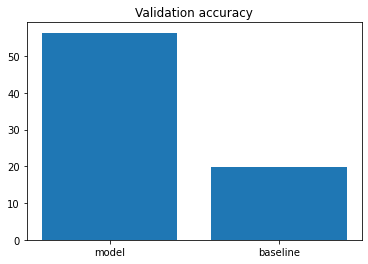

In [124]:
_ = plt.bar(x=['model','baseline'] ,height=[model_acc, naive_baseline_acc])
_ = plt.title('Validation accuracy')

# Inference

In [174]:
def get_learn_pred(txt):
    
    preds = learn.predict(txt)
    return f"Predicted review rating is {preds[0]}."

In [177]:
_  = interact(get_learn_pred, txt="This is genuinely genius. How could the plot got twisted like this! Gonna watch two more rounds.")

interactive(children=(Text(value='This is genuinely genius. How could the plot got twisted like this! Gonna wa…